In [1]:
import pandas as pd
import numpy as np
import scipy
import re
import string

import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split as split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb

import nltk
nltk.data.path
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer 
from nltk.stem import PorterStemmer, LancasterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore') 

from IPython.display import Image

%matplotlib inline
import os
import psycopg2 as pg
from sqlalchemy import create_engine
import plotly.express as px

In [2]:
#db settings
host = 'database-airbnb.cl4bob5uux9z.us-west-1.rds.amazonaws.com'
dbname= 'postgres'
user ='postgres'
port = 5432
password ='*****'

# PYTHON FUNCTION TO CONNECT TO THE POSTGRESQL DATABASE AND
# RETURN THE SQLACHEMY ENGINE OBJECT
def get_connection():
    return create_engine(
        url="postgresql://{0}:{1}@{2}:{3}/{4}".format(
            user, password, host, port, dbname
        )
    )
  
  
if __name__ == '__main__':
  
    try:
        # GET THE CONNECTION OBJECT (ENGINE) FOR THE DATABASE
        engine = get_connection().execution_options(stream_results=True)
        print(
            f"Connection to the {host} for user {user} created successfully.")
    except Exception as ex:
        print("Connection could not be made due to the following error: \n", ex)

Connection to the database-airbnb.cl4bob5uux9z.us-west-1.rds.amazonaws.com for user postgres created successfully.


In [3]:
reviews = pd.read_sql_query("SELECT listing_id, comments FROM reviews", con=engine, chunksize=1000000)

In [4]:
listings = pd.read_sql_query("SELECT * FROM listings", con=engine)

In [5]:
chunk_list = []

for chunk in reviews:
    chunk_list.append(chunk)

df_concat = pd.concat(chunk_list)

In [6]:
listings_comments = listings.merge(df_concat[['listing_id', 'comments']], left_on='id', right_on='listing_id', how='left')

In [7]:
listings_comments = listings_comments.drop('listing_id', axis=1)
listings_comments.head()

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,avg_score_rating,comments
0,23968985.0,Apartment24-Breitensee 200m away from Metro U3,756858.0,Manfred,Penzing,48.20167,16.31326,Entire home/apt,50.0,5.0,...,4.74,4.96,4.87,4.78,4.91,4.78,4.91,1,4.85,Had a great stay! Apartment was clean
1,23968985.0,Apartment24-Breitensee 200m away from Metro U3,756858.0,Manfred,Penzing,48.20167,16.31326,Entire home/apt,50.0,5.0,...,4.74,4.96,4.87,4.78,4.91,4.78,4.91,1,4.85,Wir waren absolut zufrieden mit der Unterkunft...
2,23968985.0,Apartment24-Breitensee 200m away from Metro U3,756858.0,Manfred,Penzing,48.20167,16.31326,Entire home/apt,50.0,5.0,...,4.74,4.96,4.87,4.78,4.91,4.78,4.91,1,4.85,"Foi tudo excelente, tudo preparado com muito c..."
3,23968985.0,Apartment24-Breitensee 200m away from Metro U3,756858.0,Manfred,Penzing,48.20167,16.31326,Entire home/apt,50.0,5.0,...,4.74,4.96,4.87,4.78,4.91,4.78,4.91,1,4.85,"Отличная светлая квартира, расположение прекра..."
4,23968985.0,Apartment24-Breitensee 200m away from Metro U3,756858.0,Manfred,Penzing,48.20167,16.31326,Entire home/apt,50.0,5.0,...,4.74,4.96,4.87,4.78,4.91,4.78,4.91,1,4.85,I had an incredible 2.5 month stay at Manfred’...


In [8]:
#Host listing reviews
listings_single = listings_comments.query("host_id == 757295.0")
listings_single['avg_score_rating'].mean()

4.142491680532445

In [9]:
#float format change
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [10]:
text_df = listings_single[['avg_score_rating', 'comments']]
text_df.comments.isna().sum()

2

In [11]:
text_df = text_df[~text_df.comments.isna()]
text_df = text_df[~text_df.avg_score_rating.isna()]

In [12]:
text_df['avg_score_rating'].value_counts(normalize=True)

4.41000   0.06825
4.43000   0.05743
4.26000   0.04994
4.47000   0.04786
4.28000   0.04702
4.14000   0.04619
4.16000   0.04536
4.25000   0.04245
4.15000   0.03537
4.39000   0.02871
4.37000   0.02747
3.90000   0.02497
3.95000   0.02372
4.23000   0.02206
3.67000   0.02164
4.19000   0.02122
4.35000   0.02081
4.31000   0.01998
4.29000   0.01956
4.42000   0.01831
4.02000   0.01748
4.27000   0.01748
4.49000   0.01706
4.10000   0.01665
3.82000   0.01623
3.47000   0.01581
4.03000   0.01498
4.13000   0.01415
4.33000   0.01373
3.87000   0.01248
4.30000   0.01207
4.05000   0.01124
3.89000   0.01124
3.49000   0.01040
3.65000   0.01040
4.06000   0.00874
3.29000   0.00791
4.01000   0.00791
3.98000   0.00749
3.85000   0.00707
3.80000   0.00666
3.83000   0.00583
3.71000   0.00541
3.62000   0.00499
3.45000   0.00458
4.44000   0.00458
2.99000   0.00416
3.77000   0.00416
3.66000   0.00416
2.89000   0.00375
2.57000   0.00333
3.07000   0.00250
3.57000   0.00166
2.68000   0.00166
3.11000   0.00166
3.33000   

In [13]:
text_df['comment_length'] = text_df['comments'].apply(len)
print(text_df.shape)
text_df.head()

(2403, 3)


,avg_score_rating,comments,comment_length
935661,4.16000,Muy cómodo apartamento si viajas con otra pers...,514
935662,4.16000,"Super Lage, Preisleistung und sehr netter Gast...",99
935663,4.16000,"Muy bueno, excelente ubicación y fácil acceso,...",204
935664,4.16000,"Excelente ubicación, aseo y acceso a servicios...",207
935665,4.16000,it's very nice place,20


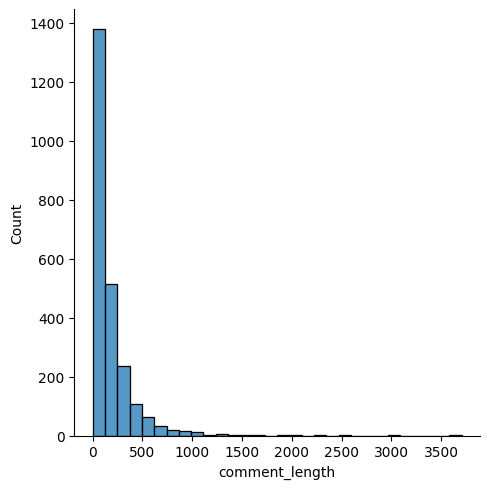

In [14]:
sns.displot(data=text_df['comment_length'], x=text_df['comment_length'], kind='hist', bins=30)

In [15]:
#avg score is 4.14
df_high_score = text_df[text_df['avg_score_rating'] >= 4.14]
df_low_score = text_df[text_df['avg_score_rating'] < 4.14]

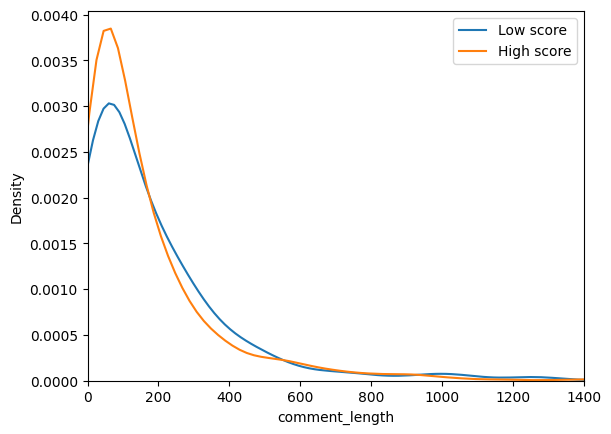

In [16]:
sns.kdeplot(data=df_low_score['comment_length'], label='Low score')
sns.kdeplot(data=df_high_score['comment_length'], label='High score')
plt.xlim(0,1400)
plt.legend()

#### Exclamation counter

In [17]:
def count_exclamation_mark(string_text):
    count = 0
    for char in string_text:
        if char == '!':
            count += 1
    return count

In [18]:
text_df['count_exc'] = text_df['comments'].apply(count_exclamation_mark)
text_df.head(5)

,avg_score_rating,comments,comment_length,count_exc
935661,4.16000,Muy cómodo apartamento si viajas con otra pers...,514,0
935662,4.16000,"Super Lage, Preisleistung und sehr netter Gast...",99,0
935663,4.16000,"Muy bueno, excelente ubicación y fácil acceso,...",204,0
935664,4.16000,"Excelente ubicación, aseo y acceso a servicios...",207,0
935665,4.16000,it's very nice place,20,0


In [19]:
text_df['count_exc'].describe(np.arange(0.2, 1.0, 0.2))

count   2403.00000
mean       0.24886
std        0.82911
min        0.00000
20%        0.00000
40%        0.00000
50%        0.00000
60%        0.00000
80%        0.00000
max       18.00000
Name: count_exc, dtype: float64

<AxesSubplot: >

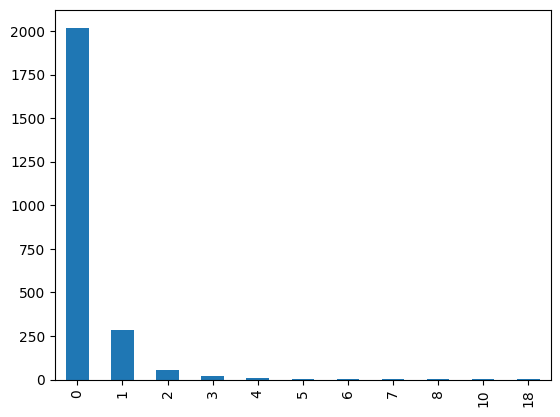

In [20]:
text_df['count_exc'].value_counts().sort_index().plot(kind='bar')

In [21]:
text_df[text_df['count_exc']== 18].index

Int64Index([1035792], dtype='int64')

In [22]:
text_df['comments'][1035792]

"So here's the deal. I'm leaving one so-so place in Vienna, Check-Out is 11 a.m. I tried to set up an earlier Check-In at Khurshed's, no go. Not a problem, I went and had a 3-hour breakfast at a nearby Pub, reading and researching to be able to meet up at 2 p.m. or 14:00 about 10 minutes away. <br/>I missed the tram and texted I'd be 15 minutes late.After several texts, it was decided 14:30. No problem. I got there at 14:13.The contact, claiming to be Kritof? after I'd asked him in texts and in person three times - but I believe was actually Ismail, showed up just after 3 p.m. What happened to 2 p.m. or 2:30? He was late for his OWN SECOND meeting time. Had he simply waited 11 minutes after his last text, I'd been in and he GONE from the scene BEFORE 2:30!!!<br/>I could've gotten at least 2 more hours of research done prior to losing another 5 hours of my day!!!*<br/>I get it!! People are running 3 or 5 different games! They are Web Designers, Distance Teachers, running restaurants and

#### Preprocessing text features

In [23]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [24]:
def punctuation_removal(messy_str):
    clean_list = [char for char in messy_str if char not in string.punctuation]
    clean_str = ''.join(clean_list)
    return clean_str

In [25]:
text_df['comments'] = text_df['comments'].apply(punctuation_removal)
text_df['comments'].head()

935661    Muy cómodo apartamento si viajas con otra pers...
935662    Super Lage Preisleistung und sehr netter Gastg...
935663    Muy bueno excelente ubicación y fácil acceso l...
935664    Excelente ubicación aseo y acceso a servicios ...
935665                                  its very nice place
Name: comments, dtype: object

Wordcloud 

In [32]:
high_score_df = text_df[text_df.avg_score_rating >= 4.3]
low_score_df = text_df[text_df.avg_score_rating < 2.5]
high_score_df

,avg_score_rating,comments,comment_length,count_exc
971329,4.33000,So I have quite a lot experience with airbnb b...,584,1
971330,4.33000,Nichts,6,0
971331,4.33000,Comfortable and minimal room,28,0
971332,4.33000,🤟,1,0
971333,4.33000,It was a very good experience highly recommend...,105,2
...,...,...,...,...
1121767,4.44000,Good value for the money Its not fancy but the...,75,0
1121768,4.44000,Passt,5,0
1121769,4.44000,Very good for the low price Location right nex...,247,0
1121770,4.44000,For the price its an excellent choice In radiu...,167,0


In [27]:
high_rating_words = []
low_rating_words = []

for comment in high_score_df.comments:
    high_rating_words.append(comment)
high_rating_words = ' '.join(high_rating_words)


for comment in low_score_df.comments:
    low_rating_words.append(comment)
low_rating_words = ' '.join(low_rating_words)


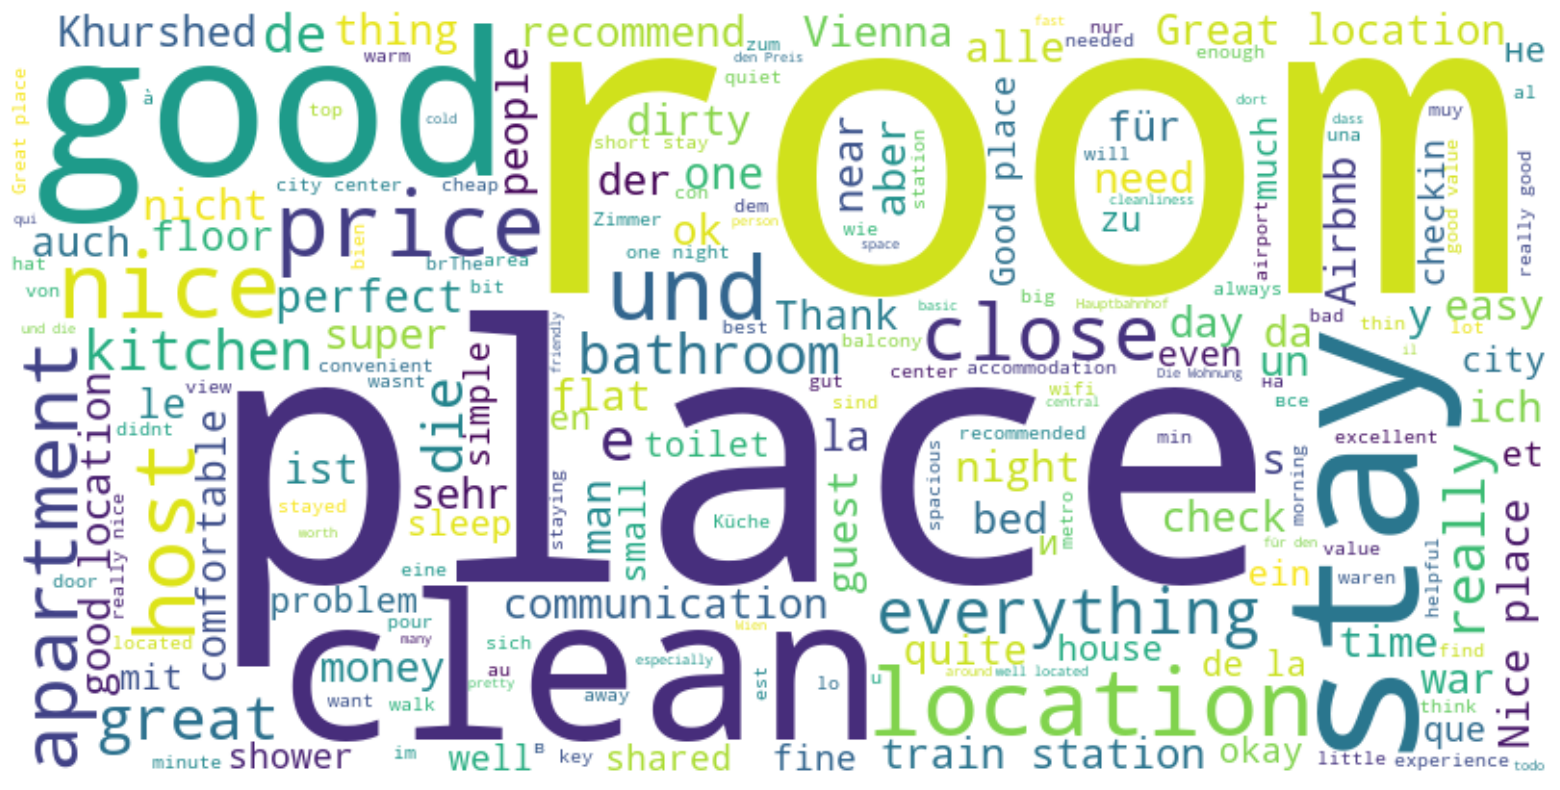

In [33]:
# wordcloud object
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(high_rating_words)

# show the image
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

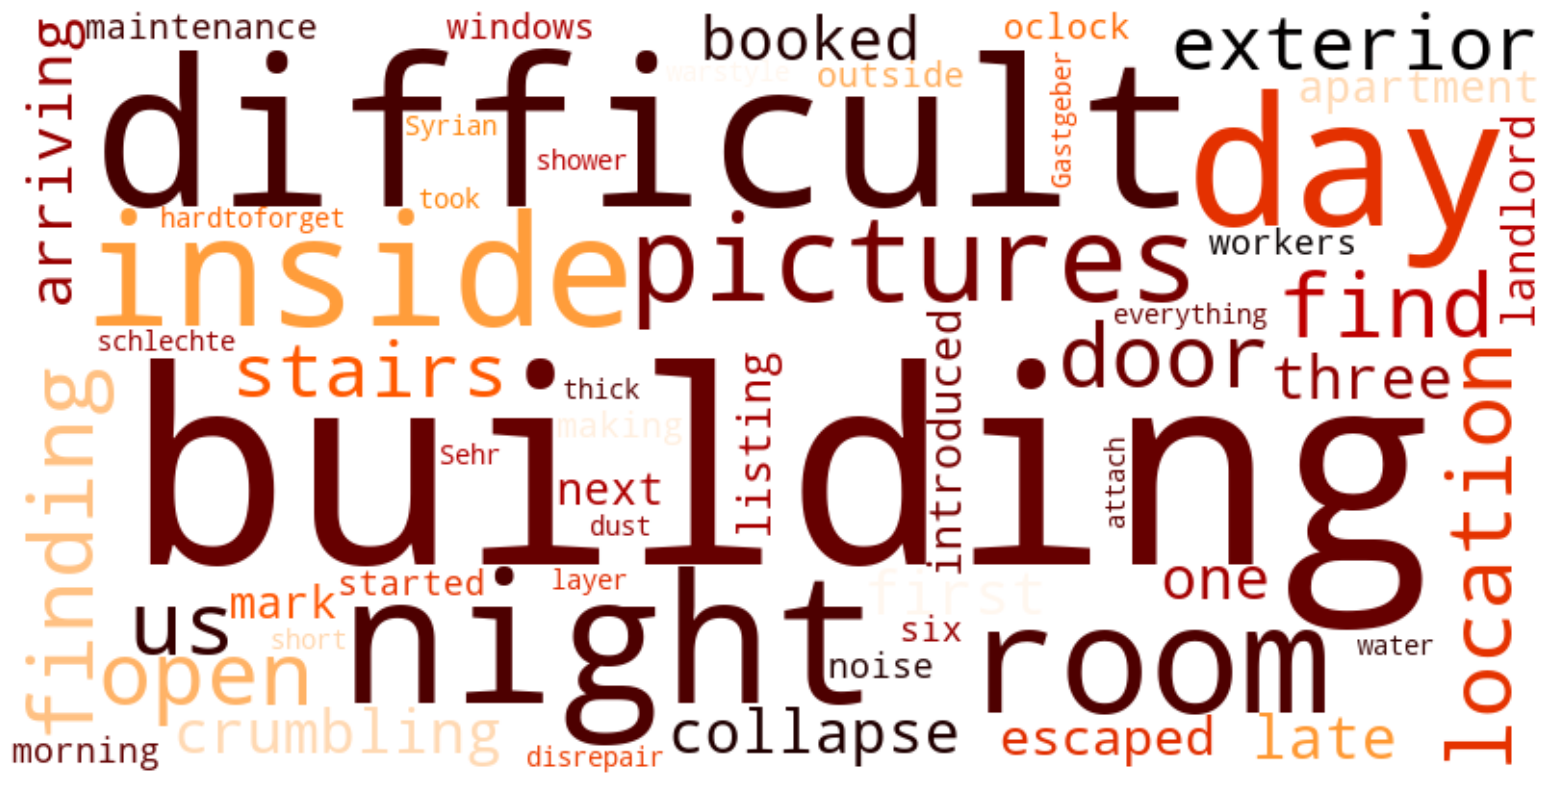

In [29]:
# wordcloud object
wordcloud = WordCloud(background_color='white', width=800, height=400, colormap='gist_heat').generate(low_rating_words)

# show the image
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()